In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dotenv import load_dotenv, find_dotenv

from ethos.constants import PROJECT_DATA
from ethos.datasets import ReadmissionDataset
from ethos.tokenize import Vocabulary
from ethos.utils import load_data

_ = load_dotenv(find_dotenv())

data_dir = PROJECT_DATA / "tokenized_datasets"

vocab = Vocabulary(data_dir / "mimic_vocab_t4367.pkl")
decode = vocab.decode

data = load_data(data_dir / "mimic_test_timelines_p26758.hdf5")
block_size = 1024
dataset = ReadmissionDataset(data, vocab.encode, block_size)
context_size = dataset.context_len
f"Number of instances: {len(dataset):,}"

'Number of instances: 42,440'

In [5]:
timeline, y = dataset[1]
decode(timeline[:]), y

(array(['SEX_M', 'RACE_WHITE', 'MARITAL_MARRIED', ..., 'ATC_SUFFIX_A05',
        '_15m-1h', 'INPATIENT_ADMISSION_END'], dtype=object),
 {'expected': 0,
  'patient_id': 11593131,
  'patient_age': 65.62353515625,
  'discharge_token_idx': 2148})

In [6]:
ctx = decode(timeline[:context_size])
patient_history = decode(timeline[context_size:])
ctx

array(['SEX_M', 'RACE_WHITE', 'MARITAL_MARRIED', '_Q7', '_65-70y',
       '_45-50y'], dtype=object)

In [7]:
def ctx_to_values(context: list):
    return {
        "gender": "male" if context[0][-1].lower() == "m" else "female",
        "race": context[1].lower()[5:],
        "marital_status": context[2].lower()[len("MARITAL_"):],
        "bmi_q": context[3][2:],
        **{
            f"age_{i}": age
            for i, age in enumerate(context[4][1:-1].split("-"))
        },
        **{
            f"year_{i}": int(year) + 1970 for i, year in enumerate(context[5][1:-1].split("-"))
        },
    }


ctx_to_values(ctx)

{'gender': 'male',
 'race': 'white',
 'marital_status': 'married',
 'bmi_q': '7',
 'age_0': '65',
 'age_1': '70',
 'year_0': 2015,
 'year_1': 2020}

In [8]:
from string import Template

PROMPT = Template("""Your task is to determine the probability of a patient being readmitted to the hospital within 30 days \
following their discharge. Using the provided patient context and a timeline of health events from their \
Electronic Health Records (EHR), perform the following steps:

1. Review the basic information about the patient to understand their general health profile.
2. Analyze the health events from the EHR data, which are detailed in a specialized language as described \
below. Consider these events in chronological order to gauge recent and relevant health activities.
3. Based on your analysis, provide a probability (as a floating point number) of the patient being readmitted within \
the next 30 days. Please focus solely on providing this probability without any additional explanatory text.

Patient Context:
```
The patient is a ${marital_status}, ${race} ${gender}, aged between ${age_0} and ${age_1} years. Their Body \
Mass Index (BMI) ranks in the ${bmi_q}th decile of the population. The health history timeline begins between \
the years ${year_0} and ${year_1}.
```

Timeline Event Language Guide:
- Lab Results (`LAB_` prefix): Represents laboratory test results. Each lab test's name is prefixed with `LAB_`, \
followed by the specific test name and its measurement units incorporated within. The result is given in a decile \
form (from `Q1` for the lowest decile to `Q10` for the highest decile), representing the patient’s result as \
compared to the general population.
- Diagnoses (`ICD_` prefix): Relates to diagnosis codes from the ICD-10 classification. Each code starts with \
`ICD_` and may be split across up to three consecutive events. The initial segment provides a plain language description \
of the condition or diagnosis. Subsequent segments delve deeper into the specific aspects of the code, enhancing the \
granularity of the diagnosis provided.
- Medications (`ATC_` prefix): Concerns medication prescriptions or administrations, coded according to the Anatomical \
Therapeutic Chemical (ATC) Classification System. Each medication event starts with `ATC_`, followed by a breakdown of up \
to three parts of the hierarchical ATC code, each part further refining the type of medication involved. The first part \
conveys the general therapeutic class.
- Time Intervals: Marks the passage of time with specific tokens (e.g., `5m-15m`, `15m-1h`, `1h-2h`, etc.). These \
intervals help contextualize the timing between health events, indicating how much time has elapsed between documented \
events. All events without a time interval token are assumed to occur simultaneously.
- Hospital Admissions (`{X}_ADMISSION_START` and `{X}_ADMISSION_END`): These tokens signify the beginning and end of a hospital \
or specific department stay. `{X}` can be replaced with `ED` for Emergency Department, `INPATIENT` for an inpatient unit, \
or `ICU` for Intensive Care Unit. Each admission event is followed by a decile ranking of the length of stay compared to other \
similar stays, and in the case of inpatient stays, also includes the associated Diagnosis-Related Group (DRG) code.
- Transfers (`TRANSFER_` prefix): Indicates when a patient is transferred between different departments within a hospital. \
The specific departments involved are appended to the prefix, giving a clear indication of the patient's movement within the \
healthcare facility.
- Additional Events: Any other events not specifically categorized by the above prefixes are described in a straightforward \
manner based on their names, assuming that their implications are clear from the context or common medical knowledge.

Patient history in the form of a timeline of health events:
```
${patient_history}
```
Use this structured information to assess the patient's likelihood of readmission. Your precise and context-aware analysis is crucial for an accurate prediction.
""")


def create_prompt(_timeline):
    _timeline = decode(_timeline)
    context, _timeline = _timeline[:context_size], _timeline[context_size:]
    _timeline = (str(t).strip().replace(" ", "_") for t in _timeline)
    _timeline = [t[1:] if t.startswith("_") else t for t in _timeline]
    return PROMPT.substitute(ctx_to_values(context), patient_history=" ".join(_timeline))


example_prompt = create_prompt(timeline)
example_prompt, len(example_prompt) / 2.6

("Your task is to determine the probability of a patient being readmitted to the hospital within 30 days following their discharge. Using the provided patient context and a timeline of health events from their Electronic Health Records (EHR), perform the following steps:\n\n1. Review the basic information about the patient to understand their general health profile.\n2. Analyze the health events from the EHR data, which are detailed in a specialized language as described below. Consider these events in chronological order to gauge recent and relevant health activities.\n3. Based on your analysis, provide a probability (as a floating point number) of the patient being readmitted within the next 30 days. Please focus solely on providing this probability without any additional explanatory text.\n\nPatient Context:\n```\nThe patient is a married, white male, aged between 65 and 70 years. Their Body Mass Index (BMI) ranks in the 7th decile of the population. The health history timeline begi

In [37]:
n_samples = 30
model_name = "gpt-3.5-turbo-0125"
batch_dir = PROJECT_DATA / "batches"
batch_dir.mkdir(exist_ok=True)

def create_batch(file_path, start, end):
    joint_prompt = ""
    with file_path.open('w') as file:
        for i in range(start, end):
            timeline, y = dataset[i]
            prompt = create_prompt(timeline)
            joint_prompt += prompt
            json_string = json.dumps({
                "custom_id": str(y["discharge_token_idx"]),
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": model_name,
                    "messages": [
                        {"role": "system", "content": "You are a prediction model able to analyse EHR data."},
                        {"role": "user", "content": prompt},
                    ],
                    "max_tokens": 10
                }
            })
            file.write(json_string + '\n')
    print(f"The OpenAI token number estimate: {len(joint_prompt) / 2.6:,.0f}")

ranges = list(range(0, 1001, n_samples))
for start, end in zip(ranges[:-1], ranges[1:]):
    file_path = batch_dir / f'readmission_batch_[{start}-{end}).jsonl'
    create_batch(file_path, start, end)

The OpenAI token number estimate: 149,484
The OpenAI token number estimate: 142,266
The OpenAI token number estimate: 156,190
The OpenAI token number estimate: 116,273
The OpenAI token number estimate: 164,726
The OpenAI token number estimate: 149,772
The OpenAI token number estimate: 150,150
The OpenAI token number estimate: 181,990
The OpenAI token number estimate: 146,807
The OpenAI token number estimate: 141,761
The OpenAI token number estimate: 162,519
The OpenAI token number estimate: 145,193
The OpenAI token number estimate: 139,506
The OpenAI token number estimate: 106,097
The OpenAI token number estimate: 118,613
The OpenAI token number estimate: 123,158
The OpenAI token number estimate: 171,915
The OpenAI token number estimate: 130,289
The OpenAI token number estimate: 147,109
The OpenAI token number estimate: 158,726
The OpenAI token number estimate: 125,847
The OpenAI token number estimate: 131,736
The OpenAI token number estimate: 123,677
The OpenAI token number estimate: 

In [38]:
from openai import OpenAI
client = OpenAI()

In [49]:
local_batch_files = list(batch_dir.glob("*.jsonl"))
len(local_batch_files)

33

In [ ]:
def delete_all(dry_run=True):
    files_to_delete = {fo.filename: fo.id for fo in client.files.list()}
    for fn, f_id in files_to_delete.items():
        if dry_run:
            print(f"Would delete {fn}:{f_id}")
        else:
            print(f"Deleting {fn}")
            client.files.delete(f_id)
delete_all(dry_run=True)

In [47]:
from tqdm import tqdm


def upload(filenames: list):
    existing_files = {fo.filename: fo.id for fo in client.files.list()}
    for fp in tqdm(filenames, desc="Uploading"):
        if fp.name not in existing_files:
            client.files.create(file=fp.open("rb"), purpose="batch")
upload(local_batch_files)

Uploading: 100%|██████████| 33/33 [00:00<00:00, 282473.53it/s]


In [66]:
def get_batches_to_run() -> dict:
    batches_filenames = [fp.name for fp in local_batch_files]
    return {
        fo.filename: fo.id for fo in client.files.list() 
        if fo.filename in batches_filenames
    }

def get_completed_batches(limit=50) -> dict:
    completed_batches = [
        batch
        for batch in client.batches.list(limit=limit).data
        if batch.status == "completed"
    ]
    completed_tasks = []
    for batch in completed_batches:
        try:
            fo = client.files.retrieve(batch.input_file_id)
            completed_tasks.append((fo.filename, batch.output_file_id))
        except Exception as e:
            pass
    return dict(completed_tasks)

batches_to_run = get_batches_to_run()

In [65]:
from time import sleep

batch_id = None
running_batches = [bo for bo in client.batches.list() if bo.status == "in_progress"]
if running_batches:
    batch_id = running_batches[0].id

while batches_to_run:
    if batch_id is None:
        completed_batches = get_completed_batches(50)
        for cb in completed_batches.keys():
            if cb in batches_to_run:
                del batches_to_run[cb]

        batch_name = next(iter(batches_to_run.keys()))
        bo = client.batches.create(
            input_file_id=batches_to_run[batch_name],
            endpoint="/v1/chat/completions",
            completion_window="24h",
        )
        batch_id = bo.id
        print(f"Started batch {batch_id} for {batch_name}.")
    else:
        bo = client.batches.retrieve(batch_id)
        if bo.status == "completed":
            batch_id = None
            print(f"Batch {bo.id} completed. Batches remaining: {len(batches_to_run) - 1}")
        else:
            print(f"Batch {bo.id} is {bo.status}.")
            sleep(30)

Started batch batch_tVWzYXXvhvzLoeoP2FsToLYB for readmission_batch_[750-780).jsonl.
Batch batch_tVWzYXXvhvzLoeoP2FsToLYB is validating.
Batch batch_tVWzYXXvhvzLoeoP2FsToLYB completed. Batches remaining: 30
Started batch batch_6i4u2tRqkwWsXeca8TovOrYx for readmission_batch_[840-870).jsonl.
Batch batch_6i4u2tRqkwWsXeca8TovOrYx is validating.
Batch batch_6i4u2tRqkwWsXeca8TovOrYx completed. Batches remaining: 29
Started batch batch_wo2POlhrSGHC1q974CNisWCA for readmission_batch_[60-90).jsonl.
Batch batch_wo2POlhrSGHC1q974CNisWCA is validating.
Batch batch_wo2POlhrSGHC1q974CNisWCA completed. Batches remaining: 28
Started batch batch_BcZpzgQ317qqYzA8y90wLHzW for readmission_batch_[660-690).jsonl.
Batch batch_BcZpzgQ317qqYzA8y90wLHzW is validating.
Batch batch_BcZpzgQ317qqYzA8y90wLHzW completed. Batches remaining: 27
Started batch batch_bXmQPqt6EfTjIzNGPvgMXhs3 for readmission_batch_[150-180).jsonl.
Batch batch_bXmQPqt6EfTjIzNGPvgMXhs3 is validating.
Batch batch_bXmQPqt6EfTjIzNGPvgMXhs3 compl

StopIteration: 

In [67]:
import json

def read_jsonl_file(file_id):
    fo = client.files.content(file_id)
    return [
        json.loads(line)
        for line in fo.iter_lines()
    ]

def get_answers(file_id) -> dict:
    responses = []
    for response in read_jsonl_file(file_id):
        custom_id = int(response["custom_id"])
        answer = response["response"]["body"]["choices"][0]["message"]["content"]
        try:
            answer = float(answer.strip())
        except ValueError:
            answer = None
        responses.append((custom_id, answer))
    return dict(responses)


answers = {}
for output_file_id in tqdm(list(get_completed_batches().values())):
    answers.update(get_answers(output_file_id))

100%|██████████| 33/33 [00:09<00:00,  3.32it/s]


In [83]:
import pandas as pd
data = (dataset[i] for i in range(1000))
results = pd.DataFrame([y for _, y in data])
results = results.join(pd.Series(answers, name="actual"), on="discharge_token_idx", how="inner")
results = results.loc[results.actual.notna()]
results

,expected,true_token_dist,true_token_time,patient_id,patient_age,discharge_token_idx,actual
0,1,604.0,7.007484,11593131,58.606831,285,0.45
1,0,NaN,NaN,11593131,65.623535,2148,0.35
2,1,82.0,0.037006,13662342,60.351105,5872,0.65
3,1,109.0,0.059303,13662342,60.378563,6403,0.12
4,1,132.0,0.043152,13662342,60.502312,7464,0.85
...,...,...,...,...,...,...,...
985,1,108.0,0.028862,14033331,66.660583,760395,0.45
986,1,95.0,0.012497,14033331,66.695839,761202,0.40
987,1,90.0,0.025787,14033331,66.732910,761523,0.82
988,1,147.0,0.042534,14033331,66.743904,761879,0.83


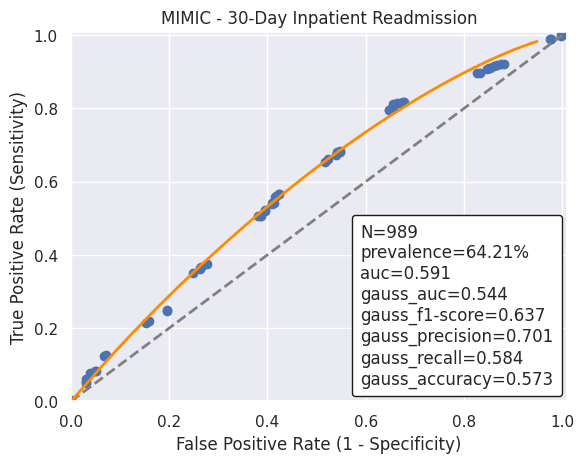

In [84]:
from ethos.metrics import compute_basic_metrics, compute_gaussian_metrics, print_auc_roc_plot

basic_res = compute_basic_metrics(results["expected"], results["actual"])
gaussian_res = compute_gaussian_metrics(results["expected"], results["actual"])
print_auc_roc_plot(
    basic_res, gaussian_res, f"MIMIC - 30-Day Inpatient Readmission"
)